# Experiments on Haar Features

In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from skimage.feature import draw_haar_like_feature

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
from general_utils.utils import get_an_example_array
from general_utils.plots import draw_our_haar_like_features
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria

### Database initialization

In [2]:
def sort_relevances(feat_importances):
    """ Get the mean importance for each feature across the runs and then sort
    them in decreasing order.
    """
    feature_importances_array = np.asarray(feat_importances)
    mean_feature_importances_array = np.mean(feature_importances_array, axis=0)
    sorted_features = np.argsort(mean_feature_importances_array)[::-1]
    sorted_mean_feature_importance = mean_feature_importances_array[sorted_features]
    return sorted_features, sorted_mean_feature_importance

In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    partitions=['train', 'validation'],
    max_lesion_diam_mm=None,
    cropped_imgs=True,
    use_muscle_mask=True,
    lesion_types=['calcification', 'cluster'],
    keep_just_images_of_lesion_type = False
)

### Instantiate Candidate Proposals Detector and Features Extractor

In [4]:
# Candidate Proposals detector
hd = HoughCalcificationDetection(filter_muscle_region=True)
# CHANGE THE DETECTOR HERE

# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature4h, 1, 4), (hm.Feature4v, 4, 1), (hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe  = CandidatesFeatureExtraction(patch_size=14, fos=False, haar_params=haar_params)

Extract features and save in disk

In [4]:
for idx in tqdm(range(len(db))):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']

    # Avoid reprocessing
    path = (Path.cwd().parent.parent / f'data/haar_features/{image_id}.fth')
    path.parent.mkdir(exist_ok=True, parents=True)
    if path.exists():
        continue
    else:
        # candidate detection
        candidates = hd.detect(
            image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

        # labeling of candidates:
        tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # Extracting features
        labels = np.where(candidates.drop_duplicates(subset='repeted_idxs').label.values == 'TP', True, False)

        # Avoid extracting features for repeted detections
        X = candidates.drop_duplicates(subset='repeted_idxs')
        X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

        # Get features dfs
        res = pd.DataFrame(data=X, columns=cfe.feature_names)
        res['img_id'] = image_id
        res['labels'] = labels

        res.to_feather(path)

100%|██████████| 167/167 [00:40<00:00,  4.16it/s]


### Handle the high dimensionality of the dataset

Generate two unified dataframes from all the cases

In [4]:
# Fraction features in two dfs
for idx in tqdm(range(80)):
    # Get case
    image_id = db.df.iloc[idx].img_id

    # Load data
    path = (Path.cwd().parent.parent / f'data/haar_features/{image_id}.fth')
    if path.exists():
        data = pd.read_feather(path)

        # Sample fp to reduce size
        TPs = data.loc[data.labels]
        n_TPs = len(TPs)
        if n_TPs == 0:
            n_FP = len(data.loc[~data.labels])
            sample_size = int(n_FP * 0.1)
        else:
            sample_size = n_TPs * 10
        if len(data.loc[~data.labels]) >= sample_size:
            FPs = data.loc[~data.labels].sample(sample_size, random_state=0, replace=False)
        else:
            FPs = data.loc[~data.labels]

        # Rejoin
        data = pd.concat([TPs, FPs], axis=0).sample(frac=1)
        if idx == 0:
            fdf = data
        else:
            fdf = pd.concat([fdf, data])
        del data, TPs, FPs
    else:
        print(f'warining: file {image_id}.fth does not exist')
# Store
fdf.reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1.fth')
del fdf

100%|██████████| 80/80 [03:20<00:00,  2.50s/it]


In [8]:
for idx in tqdm(range(80, 168)):
    # Get case
    image_id = db.df.iloc[idx].img_id

    # Load data
    path = (Path.cwd().parent.parent / f'data/haar_features/{image_id}.fth')
    if path.exists():
        data = pd.read_feather(path)

        # Sample fp to reduce size
        TPs = data.loc[data.labels]
        n_TPs = len(TPs)
        sample_size = n_TPs * 10
        if len(data.loc[~data.labels]) >= sample_size:
            FPs = data.loc[~data.labels].sample(sample_size, random_state=0, replace=False)
        else:
            FPs = data.loc[~data.labels]

        # Rejoin
        data = pd.concat([TPs, FPs], axis=0).sample(frac=1)
        if idx == 80:
            fdf = data
        else:
            fdf = pd.concat([fdf, data])
        del data, TPs, FPs
    else:
        print(f'warining: file {image_id}.fth does not exist')
 # Store
fdf.reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_bis.fth')
del fdf

### Since the complete dataset don't fit in memory, split the horizontal and rotated features

In [5]:
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1.fth')

metadata_cols = [col for col in data.columns if ('haar' not in col)]
skimage_cols = [col for col in data.columns if ('haar' in col) and ('rot' not in col) and ('hor' not in col)]
our_cols = [col for col in data.columns if ('rot' in col) or ('hor' in col)]

data.loc[:, skimage_cols+metadata_cols].reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_0_skimage.fth')
data.loc[:, our_cols+metadata_cols].reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_0_our.fth')
del data

In [ ]:
data = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_bis.fth')

metadata_cols = [col for col in data.columns if ('haar' not in col)]
skimage_cols = [col for col in data.columns if ('haar' in col) and ('rot' not in col) and ('hor' not in col)]
our_cols = [col for col in data.columns if ('rot' in col) or ('hor' in col)]

data.loc[:, skimage_cols+metadata_cols].reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_1_skimage.fth')
data.loc[:, our_cols+metadata_cols].reset_index(drop=True).to_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_1_our.fth')
del data

# OUR HAAR FEATURES

First use our features to select the 1000 most important ones

In [5]:
# Load all aour features
data = pd.concat([
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_0_our.fth'),
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_1_our.fth')
], ignore_index = True)


# CHOOSE THE NUMBER OF CASES TO CONSIDER:
N = 100
# Reduce the number of examples to be manageable
data = data.loc[data.img_id.isin(data.img_id.unique()[:N]),:]

In [8]:
# SELECT THE NUMBER OF FOLDS FOR TO USE IN THE EXPERIMENTS:
folds = 5
n = int(len(data.img_id.unique()) / folds)


# Train the Forests and store the features importances
aucs_test = []
aucs_train = []
best_10 = []
feat_importances = []
clfs = []

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), n))):
    if k == folds + 1:
        continue
    # Divide train and test based on cases (cross validation image wise)
    train_df = data[~data.img_id.isin(test_img_id)]
    train_df = train_df.sample(frac=1, random_state=0)
    test_df = data[data.img_id.isin(test_img_id)]

    # Generate features and labels datasets
    train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
    train_y = (train_df.labels).astype(int)
    del train_df
    test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
    test_y = (test_df.labels).astype(int)
    del test_df
    
    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=1000, max_depth=data.shape[1]-4, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Store the trained models
    
    filename = f'RF_our_{k}.sav'
    pickle.dump(clf, open(path / filename, 'wb'))
    
    # Asses performance
    test_y_predicted = clf.predict_proba(test_X)[:, 1]
    train_y_predicted = clf.predict_proba(train_X)[:, 1]

    auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
    auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
    aucs_test.append(auc_full_features_test)
    aucs_train.append(auc_full_features_train)

    # Store on memory the classifier and the feature importances
    clfs.append(clf)
    feat_importances.append(clf.feature_importances_)

# Store the auroc data to disk
auc_data = pd.DataFrame(aucs_test + aucs_train, columns=['auc'])
auc_data['set'] = ['val']*len(aucs_test) + ['train']*len(aucs_train)
auc_data.to_csv(path/f'aucs_our_haar_{folds}_runs.csv')
# Store the feature importances to disk
filename = f'feature_importances_our_haar_{folds}_runs.p'
pickle.dump(feat_importances, open(path/filename, 'wb'))

3it [10:46, 215.41s/it]


In [10]:
# # Analize the AUC over the folds
# sns.boxplot(data=auc_data, y='auc', x='set')
# plt.show()

Evaluate the importance of features and their influence on the performance

RUN THE FOLLOWING CELL IF YOU HAD TO KILL THE NOTEBOOK IN THE MIDDLE TO LOAD THE MODELS AND FEAURE IMPORTANCES

In [6]:
# # Load classifiers from disk
# folds = 5
# path = (Path.cwd().parent.parent / f'data/haar_models/')
# our_features_clfs = []
# for k in range(folds):
#     filename = f'RF_our_{k}.sav'
#     with open(str(path / filename), 'rb') as f:
#         cl = pickle.load(f)
#     our_features_clfs.append(cl)
# # Load the feature importances for each classifier
# feat_importances = []
# for cl in our_features_clfs:
#     feat_importances.append(cl.feature_importances_)

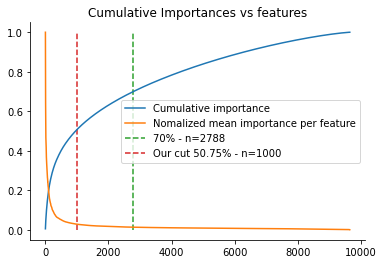

In [11]:
sorted_features, mean_importance = sort_relevances(feat_importances)
OUR_CUT = 1000

# Get the cumulative importances to analize the global percentage that we are keeping
cdf_feature_importances = np.cumsum(mean_importance/mean_importance.max())
cdf_feature_importances /= cdf_feature_importances.max()
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.70)
our_cut_importance = cdf_feature_importances[OUR_CUT]

cmap = plt.get_cmap("tab10")

plt.title('Cumulative Importances vs features')
plt.plot(cdf_feature_importances, label='Cumulative importance', c=cmap(0))
plt.plot(mean_importance/mean_importance.max(), label='Nomalized mean importance per feature', c=cmap(1))
plt.vlines(sig_feature_count, 0, 1, color=cmap(2), ls='--', label=f'70% - n={sig_feature_count}' )
plt.vlines(OUR_CUT, 0, 1, color=cmap(3), ls='--', label=f'Our cut {(our_cut_importance*100):.2f}% - n={OUR_CUT}')
sns.despine()
plt.legend()
plt.show()

In [12]:
# Load all aour features
data = pd.concat([
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_0_our.fth'),
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_1_our.fth')
], ignore_index = True)

metadata_cols = [col for col in data.columns if ('haar' not in col)]
selected_feats_cols = data.columns.values[sorted_features[:OUR_CUT]].tolist()
data.loc[:, selected_feats_cols+metadata_cols].reset_index(drop=True).to_feather(
    Path.cwd().parent.parent / f'data/haar_features/all_cases_our_features_10to1_1000_selection.fth')
del data

# SKIMAGE FEATURES

In [14]:
# Load all skimage features
data = pd.concat([
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_0_skimage.fth'),
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_1_skimage.fth')
], ignore_index = True)

# CHOOSE THE NUMBER OF CASES TO CONSIDER: IN MY CASE I COULD HANDDLE 100
N = 100
# Reduce the number of examples to be manageable
data = data.loc[data.img_id.isin(data.img_id.unique()[:N]),:]

In [16]:
# SELECT THE NUMBER OF FOLDS FOR TO USE IN THE EXPERIMENTS:
folds = 5
n = int(len(data.img_id.unique()) / folds)

# Train the Forests and store the features importances
aucs_test = []
aucs_train = []
best_10 = []
feat_importances = []
clfs = []

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), n))):
    if k == folds + 1:
        continue
    # Divide train and test based on cases (cross validation image wise)
    train_df = data[~data.img_id.isin(test_img_id)]
    train_df = train_df.sample(frac=1, random_state=0)
    test_df = data[data.img_id.isin(test_img_id)]

    # Generate features and labels datasets
    train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
    train_y = (train_df.labels).astype(int)
    del train_df
    test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
    test_y = (test_df.labels).astype(int)
    del test_df
    
    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=1000, max_depth=data.shape[1]-4, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Store the trained models
    
    filename = f'RF_skimage_{k}.sav'
    pickle.dump(clf, open(path / filename, 'wb'))
    
    # Asses performance
    test_y_predicted = clf.predict_proba(test_X)[:, 1]
    train_y_predicted = clf.predict_proba(train_X)[:, 1]

    auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
    auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
    aucs_test.append(auc_full_features_test)
    aucs_train.append(auc_full_features_train)
    
    # Store on memory the classifier and the feature importances
    clfs.append(clf)
    feat_importances.append(clf.feature_importances_)

# Store the auroc data to disk
auc_data = pd.DataFrame(aucs_test + aucs_train, columns=['auc'])
auc_data['set'] = ['val']*len(aucs_test) + ['train']*len(aucs_train)
auc_data.to_csv(path/f'aucs_skimage_haar_{folds}_runs.csv')
# Store the feature importances to disk
filename = f'feature_importances_skimage_haar_{folds}_runs.p'
pickle.dump(feat_importances, open(path/filename, 'wb'))

3it [13:30, 270.19s/it]


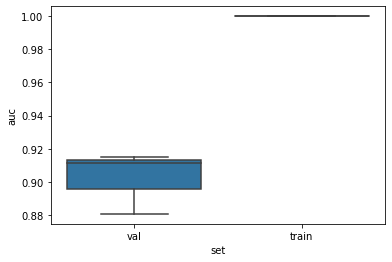

In [17]:
# sns.boxplot(data=auc_data, y='auc', x='set')
# plt.show()

RUN THE FOLLOWING CELL IF YOU HAD TO KILL THE NOTEBOOK IN THE MIDDLE TO LOAD THE MODELS AND FEAURE IMPORTANCES

In [6]:
# # Load classifiers from disk
# folds = 5
# path = (Path.cwd().parent.parent / f'data/haar_models/')
# our_features_clfs = []
# for k in range(folds):
#     filename = f'RF_skimage_{k}.sav'
#     with open(str(path / filename), 'rb') as f:
#         cl = pickle.load(f)
#     our_features_clfs.append(cl)

# # Load the feature importances for each classifier
# feat_importances = []
# for cl in our_features_clfs:
#     feat_importances.append(cl.feature_importances_)

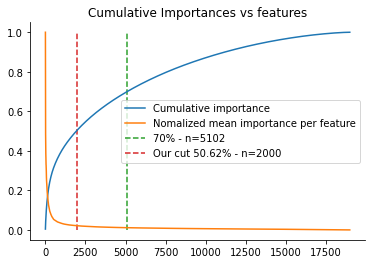

In [19]:
sorted_features, mean_importance = sort_relevances(feat_importances)
OUR_CUT = 2000

# Get the cumulative importances to analize the global percentage that we are keeping
cdf_feature_importances = np.cumsum(mean_importance/mean_importance.max())
cdf_feature_importances /= cdf_feature_importances.max()
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.70)
our_cut_importance = cdf_feature_importances[OUR_CUT]

cmap = plt.get_cmap("tab10")

plt.title('Cumulative Importances vs features')
plt.plot(cdf_feature_importances, label='Cumulative importance', c=cmap(0))
plt.plot(mean_importance/mean_importance.max(), label='Nomalized mean importance per feature', c=cmap(1))
plt.vlines(sig_feature_count, 0, 1, color=cmap(2), ls='--', label=f'70% - n={sig_feature_count}' )
plt.vlines(OUR_CUT, 0, 1, color=cmap(3), ls='--', label=f'Our cut {(our_cut_importance*100):.2f}% - n={OUR_CUT}')
sns.despine()
plt.legend()
plt.show()

In [21]:
# Load all aour features
data = pd.concat([
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_0_skimage.fth'),
    pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_train_img_10to1_1_skimage.fth')
], ignore_index = True)

metadata_cols = [col for col in data.columns if ('haar' not in col)]
selected_feats_cols = data.columns.values[sorted_features[:OUR_CUT]].tolist()
data.loc[:, selected_feats_cols+metadata_cols].reset_index(drop=True).to_feather(
    Path.cwd().parent.parent / f'data/haar_features/all_cases_skimage_features_10to1_1000_selection.fth')
del data

# SKIMAGE SELECTION + OUR SELECTION

In [17]:
our_features = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_cases_our_features_10to1_1000_selection.fth')
feature_cols = [col for col in our_features.columns if ('haar' in col)]
skimage_features = pd.read_feather(Path.cwd().parent.parent / f'data/haar_features/all_cases_skimage_features_10to1_1000_selection.fth')
data = pd.concat([our_features.loc[:, feature_cols], skimage_features], axis=1, ignore_index=True)
data.columns = feature_cols + skimage_features.columns.tolist()
data.reset_index(drop=True).to_feather(
    Path.cwd().parent.parent / f'data/haar_features/all_cases_all_features_10to1_2000_selection.fth')
del our_features, skimage_features

# CHOOSE THE NUMBER OF CASES TO CONSIDER:
N = 100
# Reduce the number of examples to be manageable
data = data.loc[data.img_id.isin(data.img_id.unique()[:N]),:]

In [20]:
# SELECT THE NUMBER OF FOLDS FOR TO USE IN THE EXPERIMENTS:
folds = 5
n = int(len(data.img_id.unique()) / folds)

# Train the Forests and store the features importances
aucs_test = []
aucs_train = []
best_10 = []
feat_importances = []
clfs = []

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), n))):
    if k == folds + 1:
        continue
    # Divide train and test based on cases (cross validation image wise)
    train_df = data[~data.img_id.isin(test_img_id)]
    train_df = train_df.sample(frac=1, random_state=0)
    test_df = data[data.img_id.isin(test_img_id)]

    # Generate features and labels datasets
    train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
    train_y = (train_df.labels).astype(int)
    del train_df
    test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
    test_y = (test_df.labels).astype(int)
    del test_df
    
    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=1000, max_depth=data.shape[1]-4, n_jobs=-1, random_state=0)
    clf.fit(train_X, train_y)

    # Store the trained models
    
    filename = f'RF_all_{k}.sav'
    pickle.dump(clf, open(path / filename, 'wb'))
    
    # Asses performance
    test_y_predicted = clf.predict_proba(test_X)[:, 1]
    train_y_predicted = clf.predict_proba(train_X)[:, 1]

    auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
    auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
    aucs_test.append(auc_full_features_test)
    aucs_train.append(auc_full_features_train)
    
    # Store on memory the classifier and the feature importances
    clfs.append(clf)
    feat_importances.append(clf.feature_importances_)

# Store the auroc data to disk
auc_data = pd.DataFrame(aucs_test + aucs_train, columns=['auc'])
auc_data['set'] = ['val']*len(aucs_test) + ['train']*len(aucs_train)
auc_data.to_csv(path/f'aucs_all_haar_{folds}_runs.csv')
# Store the feature importances to disk
filename = f'feature_importances_all_haar_{folds}_runs.p'
pickle.dump(feat_importances, open(path/filename, 'wb'))

3it [05:48, 116.11s/it]


In [15]:
# # Load classifiers from disk
# folds = 5
# path = (Path.cwd().parent.parent / f'data/haar_models/')
# our_features_clfs = []
# for k in range(folds):
#     filename = f'RF_all_{k}.sav'
#     with open(str(path / filename), 'rb') as f:
#         cl = pickle.load(f)
#     our_features_clfs.append(cl)

# # Load the feature importances for each classifier
# feat_importances = []
# for cl in our_features_clfs:
#     feat_importances.append(cl.feature_importances_)

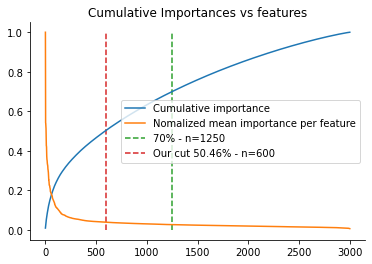

In [14]:
sorted_features, mean_importance = sort_relevances(feat_importances)
OUR_CUT = 600

# Get the cumulative importances to analize the global percentage that we are keeping
cdf_feature_importances = np.cumsum(mean_importance/mean_importance.max())
cdf_feature_importances /= cdf_feature_importances.max()
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.70)
our_cut_importance = cdf_feature_importances[OUR_CUT]

cmap = plt.get_cmap("tab10")

plt.title('Cumulative Importances vs features')
plt.plot(cdf_feature_importances, label='Cumulative importance', c=cmap(0))
plt.plot(mean_importance/mean_importance.max(), label='Nomalized mean importance per feature', c=cmap(1))
plt.vlines(sig_feature_count, 0, 1, color=cmap(2), ls='--', label=f'70% - n={sig_feature_count}' )
plt.vlines(OUR_CUT, 0, 1, color=cmap(3), ls='--', label=f'Our cut {(our_cut_importance*100):.2f}% - n={OUR_CUT}')
sns.despine()
plt.legend()
plt.show()

Evaluate the influence of the number of features

In [18]:
data = pd.read_feather(
    Path.cwd().parent.parent / f'data/haar_features/all_cases_all_features_10to1_2000_selection.fth')

# CHOOSE THE NUMBER OF CASES TO CONSIDER:
N = 30
# Reduce the number of examples to be manageable
data = data.loc[data.img_id.isin(data.img_id.unique()[:N]),:]

folds = 5
n = int(len(data.img_id.unique()) / folds)

aucs_test_feat_sel_all = {}
aucs_train_feat_sel_all = {}
aupr_test_feat_sel_all = {}
aupr_train_feat_sel_all = {}
clfs_feat_sel_all = {}

path = (Path.cwd().parent.parent / f'data/haar_models/')
path.mkdir(exist_ok=True, parents=True)

for i in [len(sorted_features), 1600, 800, 400, 200, 100, 50, 25, 10, 5, 2]:
    clfs_feat_sel_all[i] = []
    aucs_test_feat_sel_all[i] = []
    aucs_train_feat_sel_all[i] = []
    aupr_test_feat_sel_all[i] = []
    aupr_train_feat_sel_all[i] = []
    feature_selection = sorted_features[:i]

    data_ = data.iloc[:, feature_selection.astype(int).tolist() + [3000, 3001, 3002, 3003]]
    for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data_.img_id.unique(), n))):
        if k == folds + 1:
            continue

        # Divide train and test based on cases (cross validation image wise)
        train_df = data[~data.img_id.isin(test_img_id)]
        train_df = train_df.sample(frac=1, random_state=0)
        test_df = data[data.img_id.isin(test_img_id)]

        # Generate features and labels datasets
        train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
        train_y = (train_df.labels).astype(int)
        del train_df
        test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
        test_y = (test_df.labels).astype(int)
        del test_df
        
        # Train a random forest classifier
        clf = RandomForestClassifier(n_estimators=1000, max_depth=data.shape[1]-4, n_jobs=-1, random_state=0)
        clf.fit(train_X, train_y)

        # Save the model to disk
        filename = f'RF_all_performace_{i}_{k}.sav'
        pickle.dump(clf, open(path / filename, 'wb'))
        
        # Performance
        test_y_predicted = clf.predict_proba(test_X)[:, 1]
        train_y_predicted = clf.predict_proba(train_X)[:, 1]
        
        # AUROC
        aucs_test_feat_sel_all[i].append(roc_auc_score(test_y, test_y_predicted))
        aucs_train_feat_sel_all[i].append(roc_auc_score(train_y, train_y_predicted))
        
        # PR
        pr, rc, th = precision_recall_curve(test_y, test_y_predicted)
        aupr_test_feat_sel_all[i].append(auc(rc, pr))
        pr, rc, th = precision_recall_curve(train_y, train_y_predicted)
        aupr_train_feat_sel_all[i].append(auc(rc, pr))

        # Store classifiers on memory
        clfs_feat_sel_all[i].append(clf)

In [21]:
aupr_test = pd.DataFrame.from_dict(aupr_test_feat_sel_all)
aupr_test.to_csv(path/'aupr_test_all_sorted.csv')
cols = aupr_test.columns
aupr_test.reset_index(drop=False, inplace=True)
aupr_test = pd.melt(aupr_test, id_vars=['index'], value_vars=cols)

aucs_test = pd.DataFrame.from_dict(aucs_test_feat_sel_all)
aucs_test.to_csv(path/'aucs_test_all_sorted.csv')
cols = aucs_test.columns
aucs_test.reset_index(drop=False, inplace=True)
aucs_test =pd.melt(aucs_test, id_vars=['index'], value_vars=cols)

aupr_train = pd.DataFrame.from_dict(aupr_train_feat_sel_all)
aupr_train.to_csv(path/'aupr_train_all_sorted.csv')
cols = aupr_train.columns
aupr_train.reset_index(drop=False, inplace=True)
aupr_train =pd.melt(aupr_train, id_vars=['index'], value_vars=cols)

aucs_train = pd.DataFrame.from_dict(aucs_train_feat_sel_all)
aucs_train.to_csv(path/'auc_train_all_sorted.csv')
cols = aucs_train.columns
aucs_train.reset_index(drop=False, inplace=True)
aucs_train =pd.melt(aucs_train, id_vars=['index'], value_vars=cols)

In [27]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title('Auroc vs n° features')
sns.lineplot(x = aupr_test.variable, y = aupr_test.value, ax=ax, color=cmap(0), label='AUPR')
sns.lineplot(x = aucs_test.variable, y = aucs_test.value, ax=ax, color=cmap(1), label='AUROC')
ax.set_xscale('log')
ax.set_xlabel('N° features ')
ax.set_ylabel('AUROC/AUPR [mean+-std 5foldCV]')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.legend()

# Final feature Selection and visualization

Run one feature extraction if you haven't (notebook reestarted for example) in order to have the feature objects in the feature extrator

In [27]:
idx = 0
# Get image to process
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
muscle_mask = db_sample['muscle_mask']
image_mask = db_sample['lesion_mask']
# candidate detection
candidates = hd.detect(
    image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]
tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(candidates, image_mask, None, 14)
candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
X = cfe.extract_features(candidates.loc[:,['x','y','radius']].values.astype(int), image)
del X, tp, fp, fn, candidates, muscle_mask, image_id

Visualize 48 most important features

In [25]:
selected_feats_48 = data.columns.values[sorted_features[:48].astype(int)]
skimage_feats_idxs_48 = [int(i.lstrip('haar_')) for i in selected_feats_48 if ('haar' in i) and ('rot' not in i) and ('hor' not in i)]
hor_feats_idxs_48 = [int(i.lstrip('hor_haar_')) for i in selected_feats_48 if ('haar' in i) and ('hor' in i)]
rot_feats_idxs_48 = [int(i.lstrip('rot_haar_')) for i in selected_feats_48 if ('haar' in i) and ('rot' in i)]

In [ ]:
images = utils.get_an_example_array(image, 14, candidates)

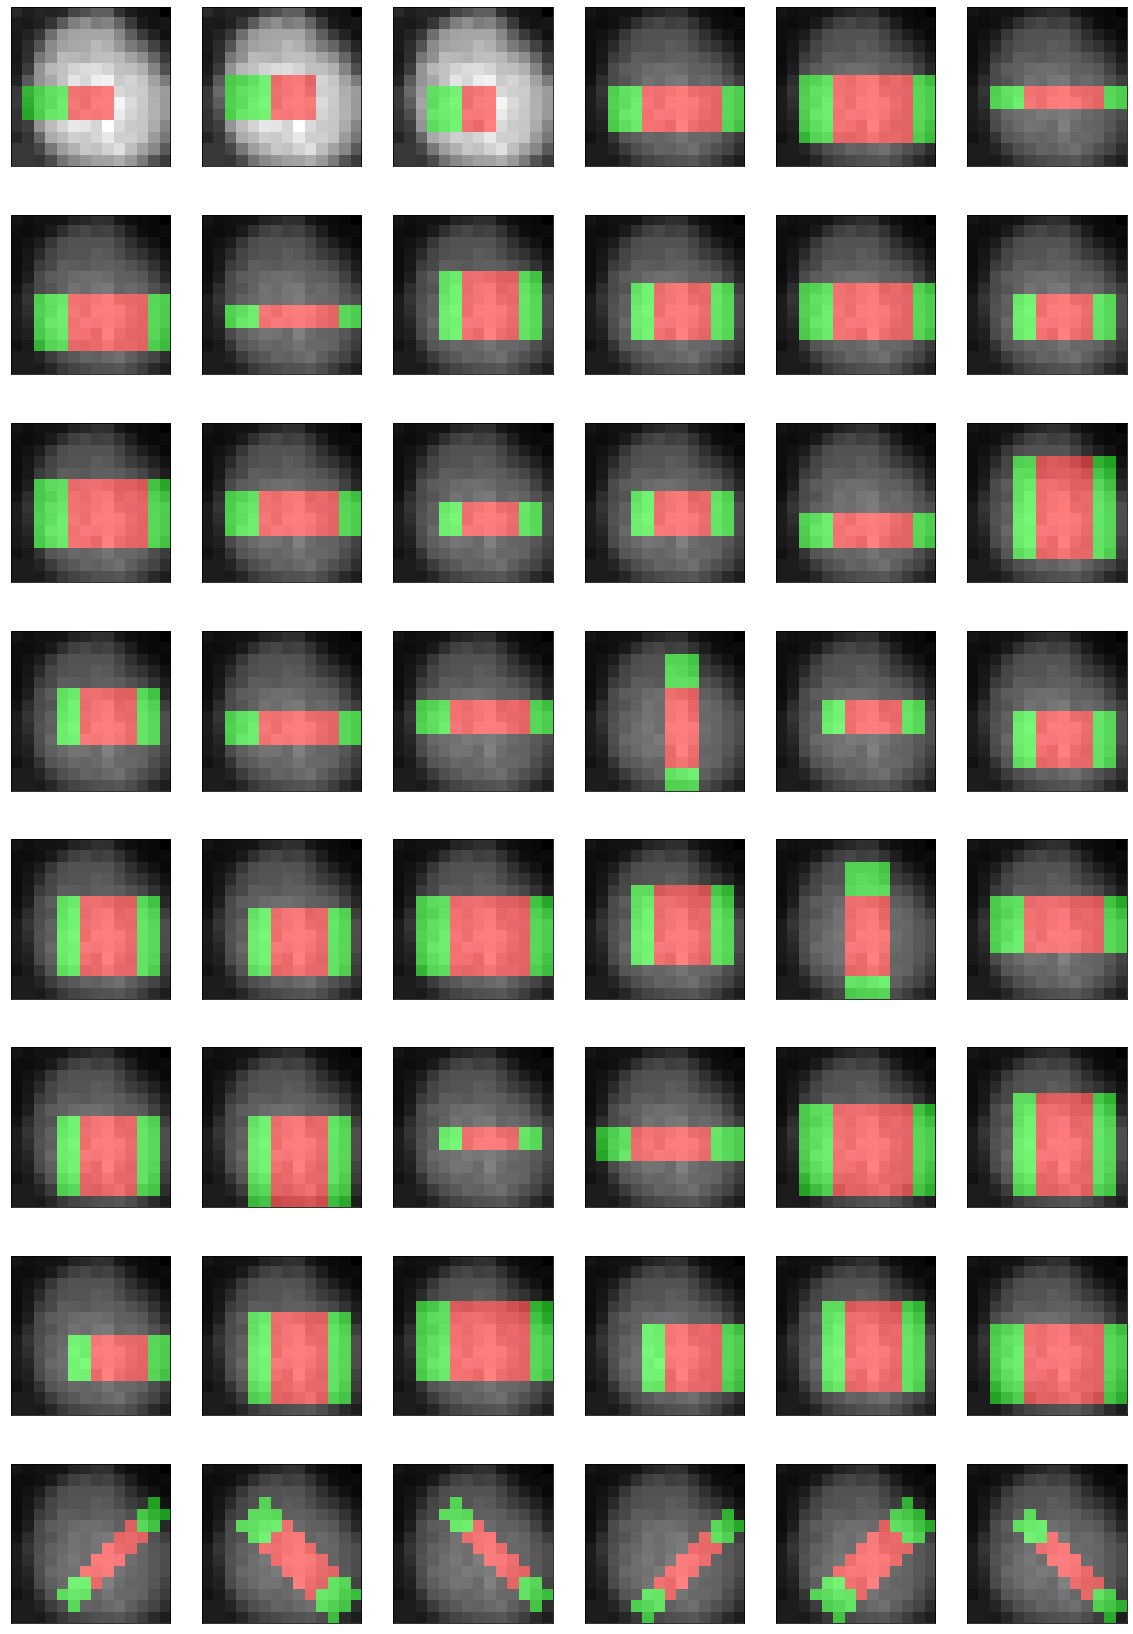

In [28]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for idx, ax in enumerate(axs.ravel()):
    img = utils.min_max_norm(images[0], 1.).astype('float')
    if idx < len(skimage_feats_idxs_48):
        img = draw_haar_like_feature(
            img, 0, 0, images.shape[2], images.shape[1], [cfe.skimage_haar_feature_coords[skimage_feats_idxs_48[idx]]]
        )
    elif idx < len(skimage_feats_idxs_48)+len(hor_feats_idxs_48):
        index = idx - len(skimage_feats_idxs_48)
        img = draw_our_haar_like_features(img, cfe.our_haar_feature_types_h[hor_feats_idxs_48[index]], rot=False)
    else:
        index = idx - len(skimage_feats_idxs_48) - len(hor_feats_idxs_48)
        img = draw_our_haar_like_features(img, cfe.our_haar_feature_types_r[rot_feats_idxs_48[index]], rot=False)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Select the final ones and save

In [ ]:
selected_feats = data.columns.values[sorted_features[:OUR_CUT].astype(int)]
skimage_feats_idxs = [int(i.lstrip('haar_')) for i in selected_feats if ('haar' in i) and ('rot' not in i) and ('hor' not in i)]
hor_feats_idxs = [int(i.lstrip('hor_haar_')) for i in selected_feats if ('haar' in i) and ('hor' in i)]
rot_feats_idxs = [int(i.lstrip('rot_haar_')) for i in selected_feats if ('haar' in i) and ('rot' in i)]

In [31]:
selection = {}
selection['skimage_haar_feature_coords_sel'] = cfe.skimage_haar_feature_coords[skimage_feats_idxs]
selection['skimage_haar_feature_types_sel'] = cfe.skimage_haar_feature_types[skimage_feats_idxs]
selection['hor_feats_selection'] = np.asarray(cfe.our_haar_feature_types_h)[hor_feats_idxs]
selection['rot_feats_selection'] = np.asarray(cfe.our_haar_feature_types_r)[rot_feats_idxs]

path = (Path.cwd().parent.parent / f'data/haar_models/')
with open(path/'final_feat_selection.p', 'wb') as f:
    pickle.dump(selection, f)

# Loading most discriminative haar features

In [4]:
path = (Path.cwd().parent.parent / f'data/haar_models/')
with open(path/'final_feat_selection.p', 'rb') as f:
    selection = pickle.load(f)

Time comparison

In [5]:
# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature4h, 1, 4), (hm.Feature4v, 4, 1), (hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe_all  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

# ISTANTIATE the candidate Feature Extractor with the selected features.
haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}
cfe_sel  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

In [8]:
import time
db_sample = db[0]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']
muscle_mask = db_sample['muscle_mask']

# candidate detection
candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

# feature extraction
start = time.time()
X = cfe_all.extract_features(candidates, image)
time_all = time.time()- start

# feature extraction
start = time.time()
X = cfe_sel.extract_features(candidates, image)
time_sel = time.time()- start

print(f'time all: {time_all}    -    time selection: {time_sel}')
print(f'time all: {time_all/len(candidates)}    -    time selection: {time_sel/len(candidates)}')

time all: 89.23793506622314    -    time selection: 7.417896270751953
time all: 0.05941273972451608    -    time selection: 0.0049386792748015666


visualize the features

In [9]:
images = utils.get_an_example_array(image, 14, candidates)

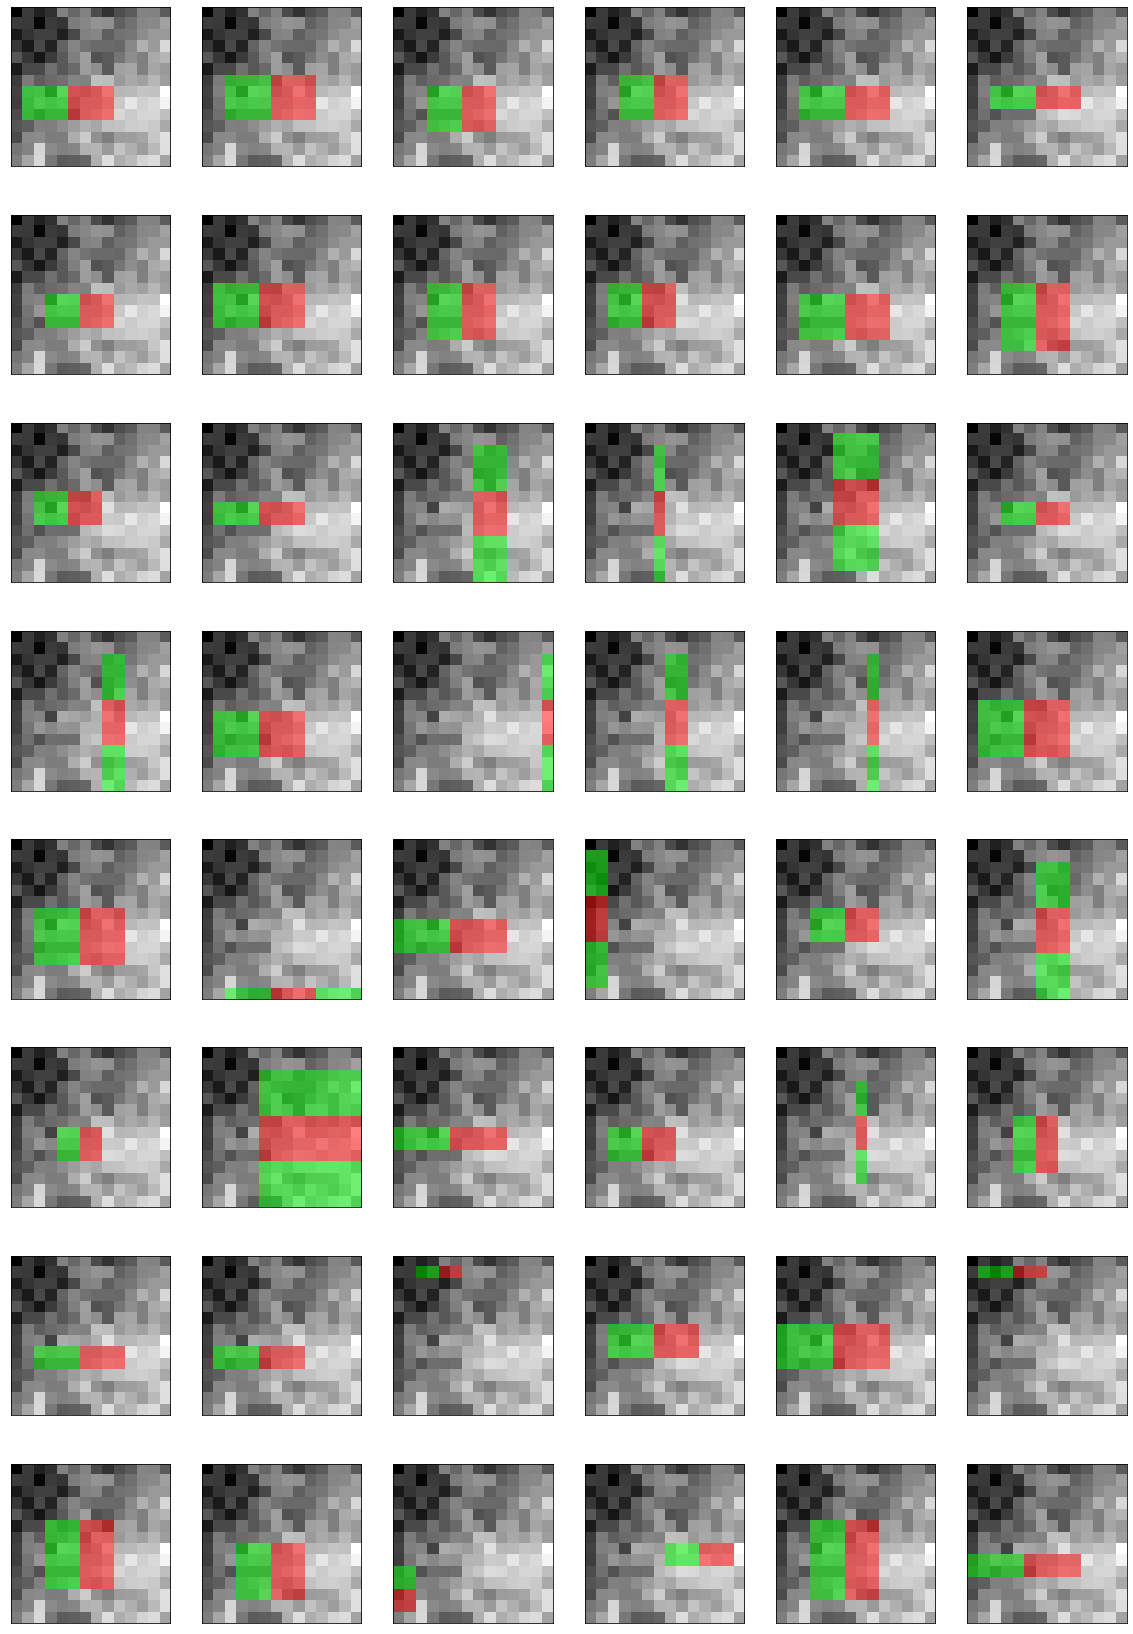

In [39]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for idx, ax in enumerate(axs.ravel()):
    img = utils.min_max_norm(images[0], 1.).astype('float')
    img = draw_haar_like_feature(
        img, 0, 0, images.shape[2], images.shape[1], [cfe_sel.skimage_haar_feature_coords[idx]])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

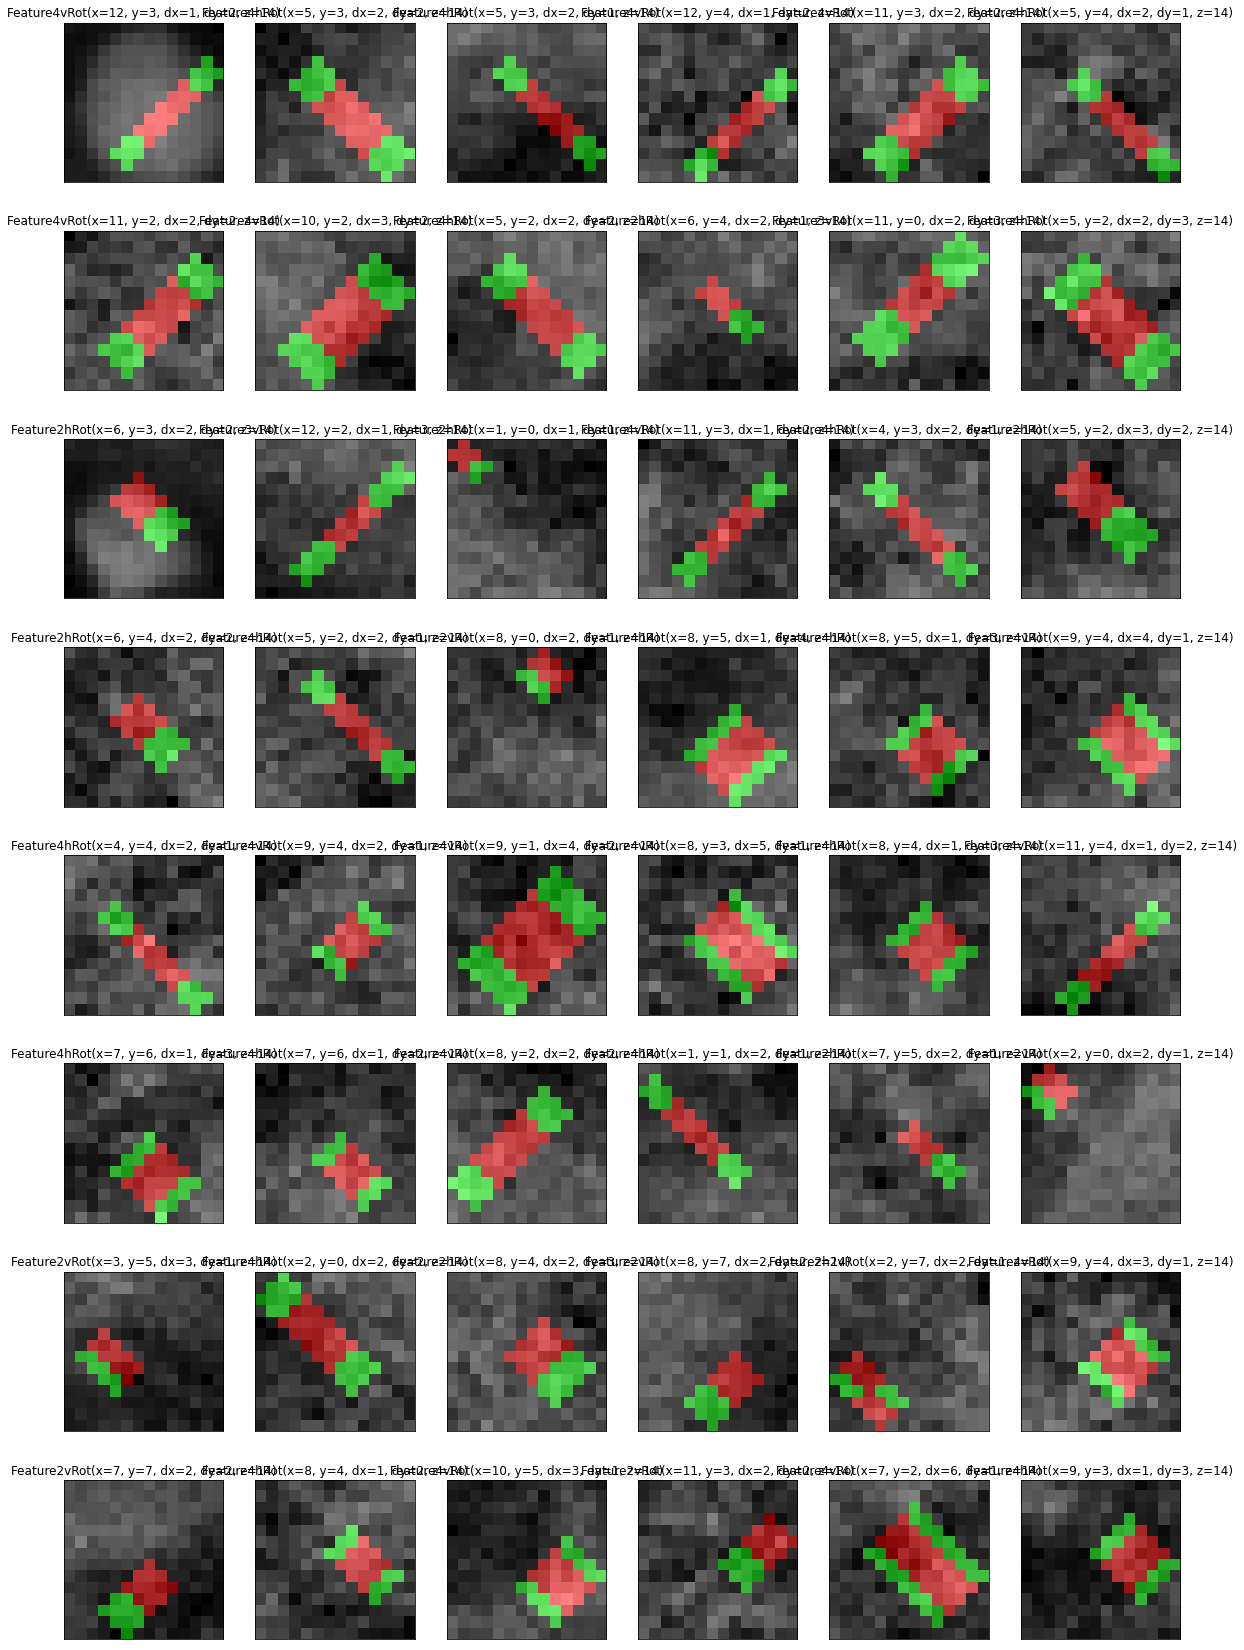

In [10]:
bfig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images, cfe_sel.our_haar_feature_types_h[:48]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

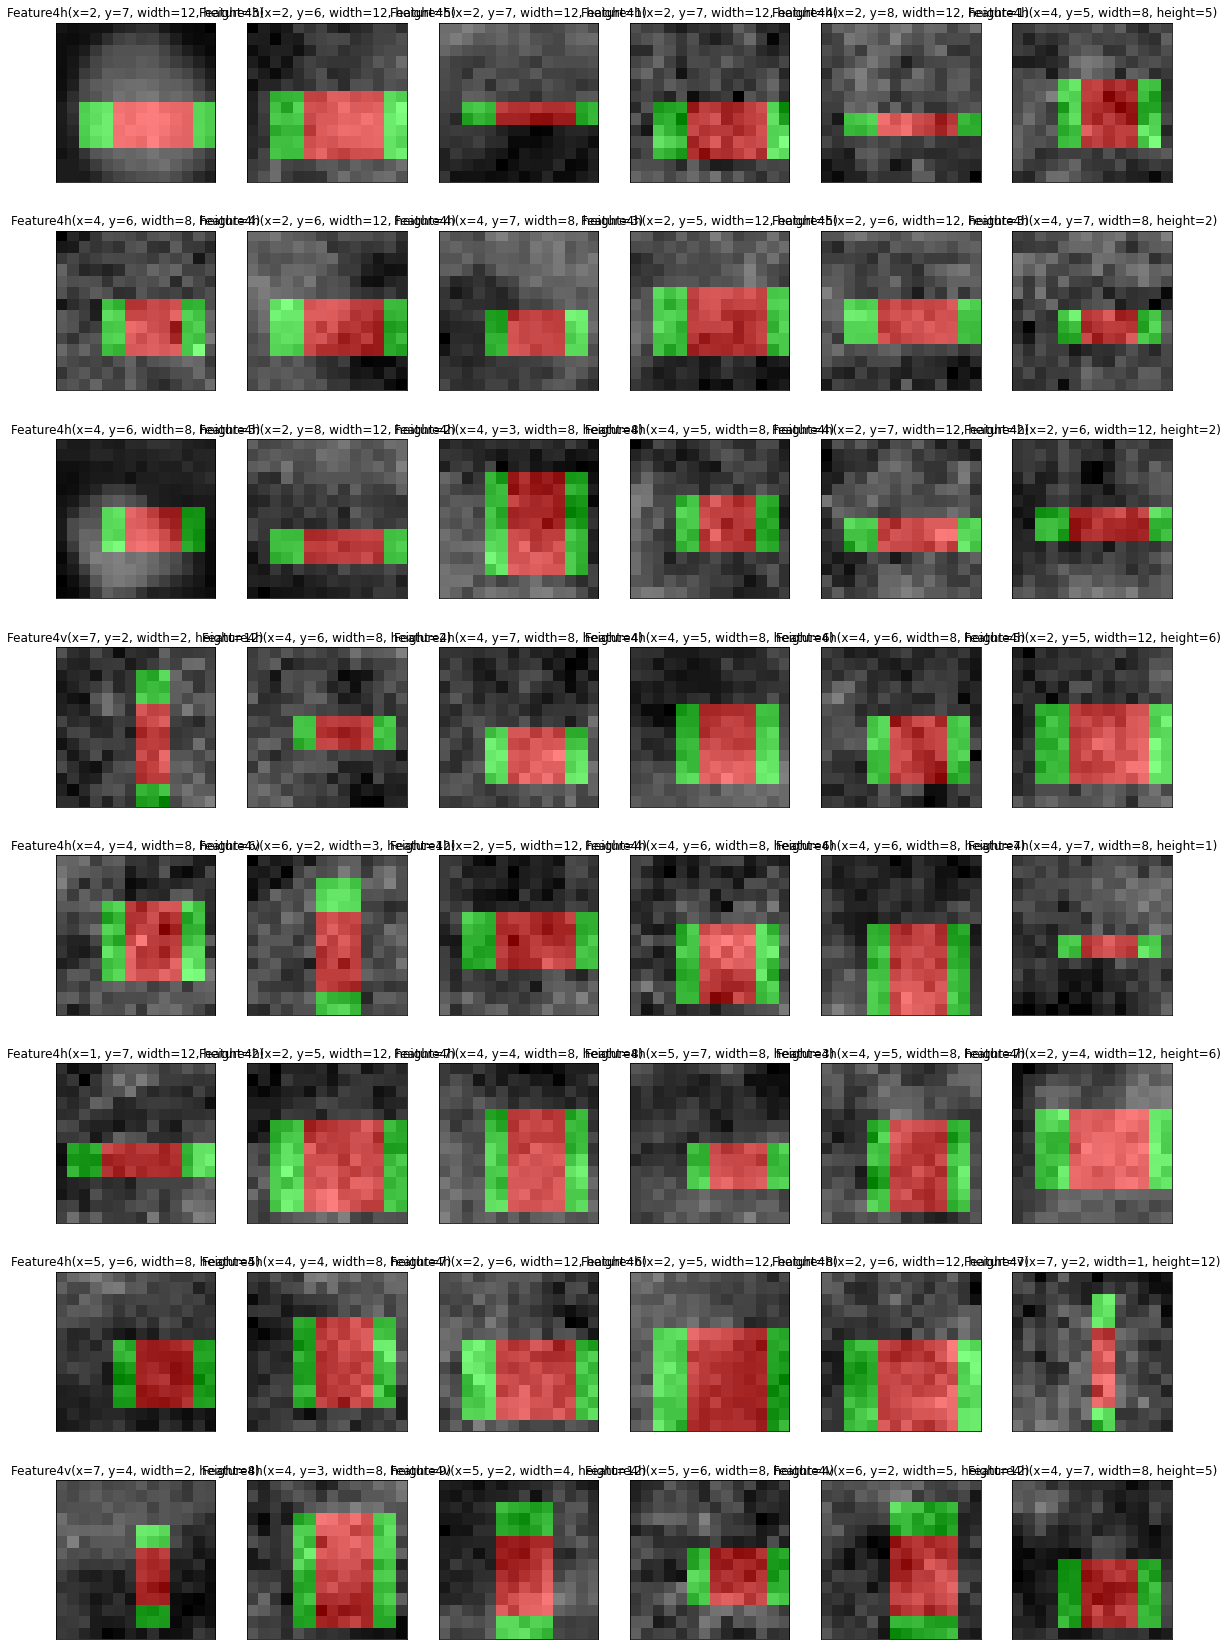

In [11]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images, cfe_sel.our_haar_feature_types_r[:48]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

IGNORE THIS ONE

In [43]:
# # Candidate Proposals detector
# hd = HoughCalcificationDetection()

# # Feature extractor
# haar_params = {
#     'skimage': {
#         'feature_type': selection['skimage_haar_feature_types_sel'],
#         'feature_coord': selection['skimage_haar_feature_coords_sel']
#     },
#     'ours': {
#         'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
#         'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
#         'rotated_feature_types': None,
#         'horizontal_feature_types': None
#     },
#     'patch_size': 14
# }
# cfe  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

# fdf = []
# for idx in tqdm(range(len(db))):
#     # Get image to process
#     db_sample = db[idx]
#     image = db_sample['img']
#     image_id = db.df.iloc[idx].img_id
#     image_mask = db_sample['lesion_mask']

#     # candidate detection
#     candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

#     # feature extraction
#     X = cfe.extract_features(candidates, image, image_mask, fp2tp_sample=10)

#     # Store in disk
#     res = pd.DataFrame(data=X, columns=cfe.feature_names)
#     res['img_id'] = image_id
#     fdf.append(res)

# data = pd.concat(fdf, ignore_index=True).sample(frac=1)
# data['center_patch_mask_intersection'] = data['center_patch_mask_intersection']>0

# aucs_test = []
# aucs_train = []
# aupr_test = []
# aupr_train = []
# aupr_curve_train = []
# aupr_curve_test = []
# auroc_curve_train = []
# auroc_curve_test = []

# total = len(list(utils.blockwise_retrieval(data.img_id.unique(), 15)))
# for k, test_img_id in tqdm(enumerate(utils.blockwise_retrieval(data.img_id.unique(), 15)), total=total):
#     if k != 0:
#         continue
#     # Partitions
#     train_df = data[~data.img_id.isin(test_img_id)]
#     test_df = data[data.img_id.isin(test_img_id)]

#     # Features and labels
#     train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
#     train_y = (train_df.center_patch_mask_intersection).astype(int)
#     test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'center_patch_mask_intersection', 'img_id'])
#     test_y = (test_df.center_patch_mask_intersection).astype(int)
    
#     # Train a random forest classifier and assess its performance
#     clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
#     clf.fit(train_X, train_y)

#     # Performance
#     test_y_predicted = clf.predict_proba(test_X)[:, 1]
#     train_y_predicted = clf.predict_proba(train_X)[:, 1]
    
#     auc_full_features_test = roc_auc_score(test_y, test_y_predicted)
#     auc_full_features_train = roc_auc_score(train_y, train_y_predicted)
#     aucs_test.append(auc_full_features_test)
#     aucs_train.append(auc_full_features_train)
#     fpr, tpr, th = roc_curve(test_y, test_y_predicted)
#     auroc_curve_test.append([fpr, tpr])
#     fpr, tpr, th = roc_curve(train_y, train_y_predicted)
#     auroc_curve_train.append([fpr, tpr])
    
#     pr, rc, th = precision_recall_curve(test_y, test_y_predicted)
#     aupr_test.append(auc(rc, pr))
#     aupr_curve_test.append([rc, pr])
#     pr, rc, th = precision_recall_curve(train_y, train_y_predicted)
#     aupr_train.append(auc(rc, pr))
#     aupr_curve_train.append([rc, pr])
#     print(f'train auc: {auc_full_features_train} - test auc: {auc_full_features_test}')

In [42]:
# plt.plot(aupr_curve_train[0][0], aupr_curve_train[0][1])
# plt.plot(auroc_curve_train[0][0], auroc_curve_train[0][1])

# plt.figure()
# plt.plot(aupr_curve_test[0][0], aupr_curve_test[0][1])
# plt.plot(auroc_curve_test[0][0], auroc_curve_test[0][1])